# 1. Import packages

In [1]:
import os
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

import logging 

In [2]:
logging.basicConfig(format='%(levelname)s: %(message)s', level=logging.INFO)
logger = logging.getLogger(__name__)

# 2. Data loading

## 2.1. Dataset description

### A toy dataset for now
#### G-10 currency pairs. Every curreny other than USD is against USD. So we have 9 pairs in total
- gbpusd, usdsek, usdnok, usdjpy, usdcad, usdchf, nzdusd, eurusd, audusd

#### Period in use: May 2019 (1 month)

## 2.2 Loading a toy data set

In [3]:
toy_path = '../dataset/'
toy_folders = ['toyset']

# csv files have no explicit column header, but column names come in this order.
# 'timestamp',  'opening', 'high', 'low', 'close', 'volume'
# As we are only interested in timestamp and close prices, we set `usecols` = [0,4], a list of indices
col_names = ['datetime',  'opening', 'high', 'low', 'close', 'volume']
usecols = [0, 2, 3]

df = {}
f = pd.DataFrame(columns=col_names)
total_size = 0
logging.info("Loading...")
for folder in toy_folders:
    files = os.listdir(toy_path+folder)
    for file in files:
        if file.endswith("05.csv"):
            logging.info(file)
            tmp = pd.read_csv(os.path.join(toy_path, folder, file),
                              delimiter=';', header=0, names=col_names, usecols=usecols)
            loaded_ccy = file[:6]
            if loaded_ccy in df.keys():
                df[loaded_ccy] = df[loaded_ccy].append(tmp, ignore_index=True)
            else:
                df[loaded_ccy] = tmp.copy()
            total_size += len(df[loaded_ccy])
logging.info("Complted.")

INFO: Loading...
INFO: audusd_DAT_ASCII_AUDUSD_M1_201905.csv
INFO: gbpusd_DAT_ASCII_GBPUSD_M1_201905.csv
INFO: usdcad_DAT_ASCII_USDCAD_M1_201905.csv
INFO: eurusd_DAT_ASCII_EURUSD_M1_201905.csv
INFO: usdchf_DAT_ASCII_USDCHF_M1_201905.csv
INFO: usdsek_DAT_ASCII_USDSEK_M1_201905.csv
INFO: nzdusd_DAT_ASCII_NZDUSD_M1_201905.csv
INFO: usdnok_DAT_ASCII_USDNOK_M1_201905.csv
INFO: usdjpy_DAT_ASCII_USDJPY_M1_201905.csv
INFO: Complted.


In [4]:
print('We have {:d} data points in total for all pairs'.format(total_size))

We have 287995 data points in total for all pairs


In [5]:
df.keys()

dict_keys(['audusd', 'gbpusd', 'usdcad', 'eurusd', 'usdchf', 'usdsek', 'nzdusd', 'usdnok', 'usdjpy'])

In [6]:
ccy_list = list(df.keys())
print('We have a list of currency pairs:', ccy_list)

We have a list of currency pairs: ['audusd', 'gbpusd', 'usdcad', 'eurusd', 'usdchf', 'usdsek', 'nzdusd', 'usdnok', 'usdjpy']


In [7]:
print('e.g.', ccy_list[0])
df[ccy_list[0]].head()

e.g. audusd


,datetime,high,low
0,20190501 000100,0.70517,0.70514
1,20190501 000200,0.70517,0.70514
2,20190501 000300,0.70517,0.70517
3,20190501 000400,0.70518,0.70517
4,20190501 000500,0.70518,0.70517


#### We do not have ask prices in our data set.
- We take high prices as `ask_price` and low prices as `bid_price` for now just until we have a new data set.

In [8]:
df['eurusd'].columns

Index(['datetime', 'high', 'low'], dtype='object')

In [9]:
for ccy in ccy_list:
    df[ccy].rename(columns={'high': 'ask_price', 'low': 'bid_price'}, inplace=True)

## 2.3 Data Integrity Check

In [10]:
for i, ccy in enumerate(ccy_list):
    desc = df[ccy].describe()
    desc.rename(columns={'ask_price': ccy+'_ask', 'bid_price':ccy+'_bid'}, inplace=True)
    if i == 0:
        df_desc = desc.copy()
    else:
        df_desc = pd.merge(df_desc, desc, left_index=True, right_index=True)

- Outliers: none.
- Index: The number of data points a little vary. See the **2.5 `timestamp` policy** to handle this.

In [11]:
df_desc

,audusd_ask,audusd_bid,gbpusd_ask,gbpusd_bid,usdcad_ask,usdcad_bid,eurusd_ask,eurusd_bid,usdchf_ask,usdchf_bid,usdsek_ask,usdsek_bid,nzdusd_ask,nzdusd_bid,usdnok_ask,usdnok_bid,usdjpy_ask,usdjpy_bid
count,31946.000000,31946.000000,31953.000000,31953.000000,31900.000000,31900.000000,31968.000000,31968.000000,31871.000000,31871.000000,31616.000000,31616.000000,31885.000000,31885.000000,32383.000000,32383.000000,32473.000000,32473.000000
mean,0.694530,0.694438,1.285139,1.284985,1.345870,1.345737,1.118613,1.118509,1.011103,1.011012,9.596976,9.595584,0.656137,0.656059,8.740825,8.739539,110.015410,110.003956
std,0.004925,0.004917,0.017836,0.017832,0.003246,0.003238,0.002978,0.002973,0.005351,0.005350,0.043117,0.043147,0.004287,0.004279,0.034109,0.034058,0.684108,0.685476
min,0.686470,0.686440,1.256290,1.255900,1.336170,1.335710,1.111240,1.110700,1.000250,1.000060,9.469900,9.468420,0.648210,0.648130,8.609150,8.607350,108.285000,108.277000
25%,0.691100,0.691010,1.267360,1.267200,1.343670,1.343560,1.116350,1.116270,1.007450,1.007330,9.566308,9.564930,0.652390,0.652320,8.719160,8.718090,109.551000,109.540000
50%,0.692870,0.692800,1.284000,1.283810,1.346150,1.346040,1.118780,1.118630,1.009590,1.009510,9.600090,9.598530,0.655690,0.655590,8.748570,8.747320,109.815000,109.796000
75%,0.699320,0.699230,1.302110,1.301910,1.347600,1.347480,1.120640,1.120550,1.016550,1.016420,9.634173,9.632803,0.659480,0.659390,8.764320,8.762980,110.348000,110.336000
max,0.706070,0.705980,1.317620,1.317360,1.356440,1.356270,1.126470,1.126210,1.022590,1.022250,9.687630,9.686170,0.666510,0.666420,8.804460,8.803100,111.699000,111.657000


In [12]:
max_datapoints = np.max(df_desc.loc['count'])
max_datapoints

32473.0

## 2.4 Drop from and add some columns to `df`

- Drop: `datetime` (no use)
- Add: `ccy`, `timestamp`
- Retain: `bid_price`, `ask_price`

In [13]:
for ccy in ccy_list:
    df[ccy]['ccy'] = ccy
    df[ccy]['timestamp'] = df[ccy].datetime.apply(lambda x: pd.to_datetime(x))
    cols_to_use = ['timestamp', 'ccy', 'bid_price', 'ask_price']
    df[ccy] = df[ccy][cols_to_use]

In [14]:
#rand_ccy = ccy_list[np.random.randint(len(ccy_list))]
rand_ccy='usdjpy'
df[rand_ccy].sample(5)

,timestamp,ccy,bid_price,ask_price
13168,2019-05-14 03:53:00,usdjpy,109.698,109.706
15448,2019-05-15 17:56:00,usdjpy,109.583,109.584
21393,2019-05-21 21:07:00,usdjpy,110.517,110.527
16582,2019-05-16 12:50:00,usdjpy,109.849,109.858
14099,2019-05-14 19:25:00,usdjpy,109.658,109.660


### Check if we have all data points in `df`

In [15]:
assert np.sum([len(df[ccy]) for ccy in ccy_list]) == total_size, "We got some data loss."

## 2.5 Padding missing time to `df`

### Creating a new index `idx`
#### `timestamp` policy:
- If any curency pair has any price at timestamp $t$, then we have the timestamp $t$ for the rest of the currency pairs as well.

#### We create a union set `idx` of `timestamp` for every currency pair so that we can cover every data point.

In [16]:
ccy_idx = {}
for i, ccy in enumerate(ccy_list):
    ccy_idx[ccy] = pd.Index(df[ccy].timestamp)
    if i == 0 :
        idx = pd.Index(ccy_idx[ccy])
    else:
        idx = idx.union(ccy_idx[ccy])

#### Apply `idx` to every `df[ccy]`

In [17]:
for ccy in ccy_list:
    df_ccy = pd.DataFrame(index=idx)
    df[ccy] = df_ccy.merge(df[ccy], how='left', on='timestamp')
    df[ccy]['ccy'].fillna(ccy, inplace=True)

In [18]:
assert np.min([df[f].shape[0] for f in df.keys()]) >= max_datapoints, "We got some data loss."

#### We get the global earliest date and last date over the entire data set.

## 2.6 Create the data set `X`
### We do it simply by appending `df` for each currency pair to create the data set `X`

Create a template for `X`

In [19]:
X = pd.DataFrame(columns = df[ccy_list[0]].columns)
X

,timestamp,ccy,bid_price,ask_price


In [20]:
for ccy in ccy_list:
    X = X.append(df[ccy], ignore_index=False, sort=False)

In [21]:
X.sample(5)

,timestamp,ccy,bid_price,ask_price
16452,2019-05-16 10:13:00,usdchf,1.01007,1.01024
10716,2019-05-10 10:37:00,audusd,0.70034,0.70045
6752,2019-05-07 16:33:00,usdnok,8.74850,8.74892
28318,2019-05-28 18:58:00,gbpusd,1.26570,1.26571
5234,2019-05-06 15:15:00,usdsek,9.55556,9.55653


## 2.7 Missing Data Analysis
#### An imputing policy:
- First we sort `X` by `ccy` and `timestamp`, and reset the index.
- Then we group `X` by `ccy`
- We finally forwardfill (use previous values to fill missing values)

In [22]:
X = X.sort_values(by=['ccy','timestamp'])
X.reset_index(drop=True, inplace=True)

### Missing data
- `bid_price`: 4,676
- `ask_price`: 4,676
- We impute them by previous values (done by group)

In [23]:
X.isna().sum()

timestamp       0
ccy             0
bid_price    4676
ask_price    4676
dtype: int64

In [24]:
g = X.groupby('ccy')
X['bid_price'] = g['bid_price'].fillna(method='ffill')
X['ask_price'] = g['ask_price'].fillna(method='ffill')

#### Now we have no missing value. Cleaning is *done*.

In [25]:
X.isna().sum()

timestamp    0
ccy          0
bid_price    0
ask_price    0
dtype: int64

## 2.8 Calculate `bid_ret`, `ask_ret` and `mid_price`

In [26]:
X.loc[X['ccy'] == X['ccy'].shift(), 'bid_ret'] = np.log(X['bid_price']) - np.log(X['bid_price'].shift())
X.loc[X['ccy'] == X['ccy'].shift(), 'ask_ret'] = np.log(X['ask_price']) - np.log(X['ask_price'].shift())
X['mid_price'] = X['ask_price'] - X['bid_price']

In [27]:
X_boundary = X.loc[X['ccy'] != X['ccy'].shift()]
X_boundary

,timestamp,ccy,bid_price,ask_price,bid_ret,ask_ret,mid_price
0,2019-05-01 00:01:00,audusd,0.70514,0.70517,NaN,NaN,0.00003
32519,2019-05-01 00:01:00,eurusd,1.12182,1.12188,NaN,NaN,0.00006
65038,2019-05-01 00:01:00,gbpusd,1.30426,1.30430,NaN,NaN,0.00004
97557,2019-05-01 00:01:00,nzdusd,0.66488,0.66490,NaN,NaN,0.00002
130076,2019-05-01 00:01:00,usdcad,1.33774,1.33776,NaN,NaN,0.00002
162595,2019-05-01 00:01:00,usdchf,1.01927,1.01930,NaN,NaN,0.00003
195114,2019-05-01 00:01:00,usdjpy,111.48800,111.48900,NaN,NaN,0.00100
227633,2019-05-01 00:01:00,usdnok,8.62020,8.62055,NaN,NaN,0.00035
260152,2019-05-01 00:01:00,usdsek,9.48740,9.48757,NaN,NaN,0.00017


In [28]:
X.dropna(axis='index', how='any', inplace=True)

In [29]:
X.isna().sum()

timestamp    0
ccy          0
bid_price    0
ask_price    0
bid_ret      0
ask_ret      0
mid_price    0
dtype: int64

In [30]:
X.reset_index(drop=True, inplace=True)

In [31]:
X.head()

,timestamp,ccy,bid_price,ask_price,bid_ret,ask_ret,mid_price
0,2019-05-01 00:02:00,audusd,0.70514,0.70517,0.000000,0.000000,0.00003
1,2019-05-01 00:03:00,audusd,0.70517,0.70517,0.000043,0.000000,0.00000
2,2019-05-01 00:04:00,audusd,0.70517,0.70518,0.000000,0.000014,0.00001
3,2019-05-01 00:05:00,audusd,0.70517,0.70518,0.000000,0.000000,0.00001
4,2019-05-01 00:06:00,audusd,0.70517,0.70518,0.000000,0.000000,0.00001


## 2.9 Let's plot for a visual check.

In [32]:
# Code: https://stackoverflow.com/questions/11640243/pandas-plot-multiple-y-axes
def plot_multi(data, cols=None, spacing=.1, **kwargs):

    from pandas import plotting

    # Get default color style from pandas - can be changed to any other color list
    if cols is None: cols = data.columns
    if len(cols) == 0: return
    colors = getattr(getattr(plotting, '_matplotlib').style, '_get_standard_colors')(num_colors=len(cols))

    # First axis
    ax = data.loc[:, cols[0]].plot(label=cols[0], color=colors[0], **kwargs)
    ax.set_ylabel(ylabel=cols[0])
    ax.tick_params(axis='y', colors=colors[0])
    lines, labels = ax.get_legend_handles_labels()

    for n in range(1, len(cols)):
        # Multiple y-axes
        ax_new = ax.twinx()
        ax_new.spines['right'].set_position(('axes', 1 + spacing * (n - 1)))
        data.loc[:, cols[n]].plot(ax=ax_new, label=cols[n], color=colors[n % len(colors)])
        ax_new.set_ylabel(ylabel=cols[n])
        ax_new.tick_params(axis='y', colors=colors[n % len(colors)])

        # Proper legend position
        line, label = ax_new.get_legend_handles_labels()
        lines += line
        labels += label

    ax.legend(lines, labels, loc=0)
    return ax

In [33]:
bid_dict = dict()
ask_dict = dict()
for ccy in ccy_list:
    bid_dict[ccy] = X[X.ccy==ccy].bid_price.reset_index(drop=True)
    ask_dict[ccy] = X[X.ccy==ccy].ask_price.reset_index(drop=True)
X_bid = pd.DataFrame(bid_dict)
X_ask = pd.DataFrame(ask_dict)

In [34]:
X_bid.head()

,audusd,gbpusd,usdcad,eurusd,usdchf,usdsek,nzdusd,usdnok,usdjpy
0,0.70514,1.30425,1.33776,1.12182,1.01928,9.48757,0.66485,8.62052,111.488
1,0.70517,1.30435,1.33777,1.12182,1.01928,9.48757,0.66489,8.62105,111.488
2,0.70517,1.30426,1.33781,1.12182,1.01928,9.48757,0.66489,8.62104,111.489
3,0.70517,1.30427,1.33783,1.12179,1.01927,9.48757,0.66488,8.62111,111.487
4,0.70517,1.30427,1.33784,1.12180,1.01928,9.48790,0.66488,8.62132,111.488


In [35]:
X_ask.head()

,audusd,gbpusd,usdcad,eurusd,usdchf,usdsek,nzdusd,usdnok,usdjpy
0,0.70517,1.30439,1.33780,1.12184,1.01928,9.48757,0.66490,8.62105,111.489
1,0.70517,1.30439,1.33781,1.12183,1.01928,9.48757,0.66491,8.62106,111.489
2,0.70518,1.30437,1.33784,1.12183,1.01928,9.48757,0.66490,8.62124,111.489
3,0.70518,1.30438,1.33788,1.12183,1.01929,9.48791,0.66490,8.62135,111.489
4,0.70518,1.30431,1.33787,1.12181,1.01929,9.48791,0.66489,8.62141,111.488


#### Bid prices

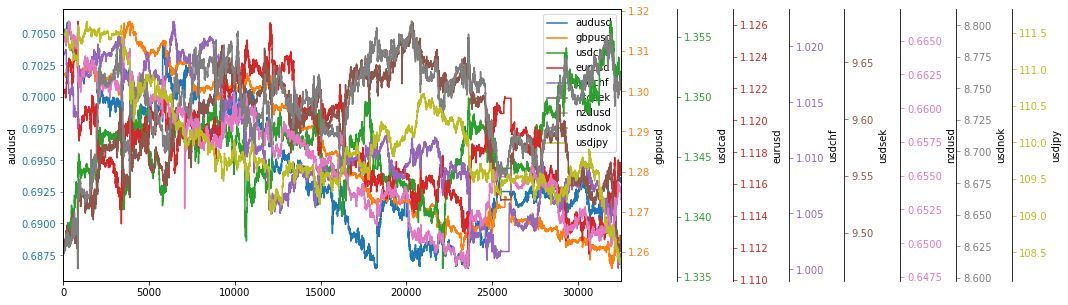

In [36]:
plot_multi(X_bid, figsize=(10, 5))

#### Ask prices

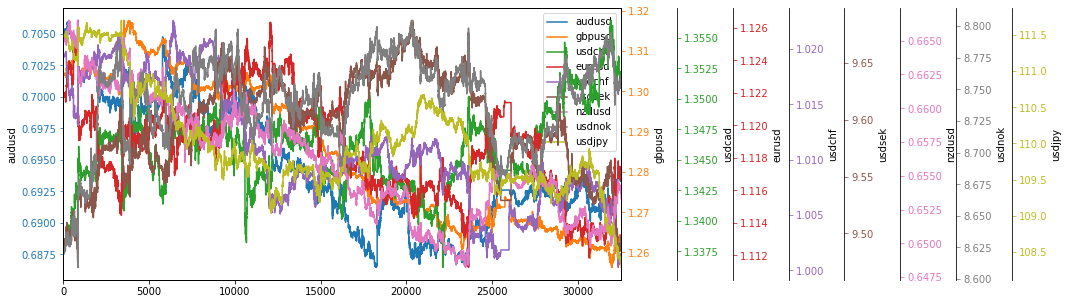

In [37]:
plot_multi(X_ask, figsize=(10, 5))

# 3. Data set `X` is ready

## 3.1 Take a look

In [38]:
X.shape

(292662, 7)

In [39]:
X.sample(5)

,timestamp,ccy,bid_price,ask_price,bid_ret,ask_ret,mid_price
66379,2019-05-01 22:25:00,gbpusd,1.30539,1.30544,0.000015,-0.000023,0.00005
183019,2019-05-21 04:31:00,usdchf,1.01048,1.01050,0.000000,-0.000158,0.00002
97726,2019-05-01 02:54:00,nzdusd,0.66478,0.66479,0.000000,-0.000015,0.00001
264392,2019-05-05 22:50:00,usdsek,9.57353,9.57383,0.000063,-0.000010,0.00030
17619,2019-05-17 05:41:00,audusd,0.68740,0.68755,-0.000102,0.000015,0.00015


In [40]:
X[X.ccy=='gbpusd'].head(5)

,timestamp,ccy,bid_price,ask_price,bid_ret,ask_ret,mid_price
65036,2019-05-01 00:02:00,gbpusd,1.30425,1.30439,-0.000008,0.000069,0.00014
65037,2019-05-01 00:03:00,gbpusd,1.30435,1.30439,0.000077,0.000000,0.00004
65038,2019-05-01 00:04:00,gbpusd,1.30426,1.30437,-0.000069,-0.000015,0.00011
65039,2019-05-01 00:05:00,gbpusd,1.30427,1.30438,0.000008,0.000008,0.00011
65040,2019-05-01 00:06:00,gbpusd,1.30427,1.30431,0.000000,-0.000054,0.00004


## Split: Training set and Validation set(=evaluation set)
- Training set `X_train`: The first two and a half weeks (From May 1, 2019 to May 19, 2019)
- Validation set `X_val`: The following one week (From May 20, 2019 to May 26, 2019)
- Test set `X_test`: The rest of days (From May 27, 2019 to May 31, 2019)
  - In fact, we never create `X_test` until the very last moment.

In [41]:
X_train = X[(X.timestamp >= pd.datetime(2019, 5, 1)) &
            (X.timestamp < pd.datetime(2019, 5, 20))]
X_val = X[(X.timestamp >= pd.datetime(2019, 5, 20)) &
          (X.timestamp < pd.datetime(2019, 5, 27))]

In [42]:
X.drop(X[(X.timestamp >= pd.datetime(2019, 5, 27)) & (
    X.timestamp < pd.datetime(2019, 6, 1))].index, inplace=True)

In [43]:
X.tail()

,timestamp,ccy,bid_price,ask_price,bid_ret,ask_ret,mid_price
285878,2019-05-26 23:55:00,usdsek,9.52895,9.52895,0.0,0.0,0.0
285879,2019-05-26 23:56:00,usdsek,9.52895,9.52895,0.0,0.0,0.0
285880,2019-05-26 23:57:00,usdsek,9.52895,9.52895,0.0,0.0,0.0
285881,2019-05-26 23:58:00,usdsek,9.52895,9.52895,0.0,0.0,0.0
285882,2019-05-26 23:59:00,usdsek,9.52895,9.52895,0.0,0.0,0.0


### The end of preprocessing ------------------------------------------------

# environment.py

In [44]:
import numpy as np
import pandas as pd

In [45]:
class ForexEnv(object):
    '''
    Observation:
        self.timestamp
        self.state =   3 (the day of the week, hour, minute) +
                       3 (the previous position; {-1, 0, 1}) + 
                      20 (the 10-minute bid and ask prices of the target currency) +
                      80 (the 10-minute mid prices of the rest of 8 currency pairs)
                   = 106 (total)
        self.price_record: bid and ask prices of the target currency
        
    Actions:
        -1: short 100%
         0: take a neutral position
        +1: long 100%
        
    Starting State:
        random start within training set.
        i.e., we pick an arbitrary number and take it as index to start with.                 
    '''
    
    def __init__(self, cur='eurusd', lag=10, min_history=1440, mode='train'):
        self.ccy = cur
        self.lag = lag
        self.min_history = min_history
        self.index = None
        self.state = None
        self.price_record = None
        self.X_train = X_train
        self.X_val = X.val
        self.trainframe = self.X_train.index.values.tolist()
        self.valframe = self.X_val.index.values.tolist()
        self.train = self.trainframe[:-self.min_history]
        self.val = self.valframe[:-self.min_history]
        self.mode = mode

# experiment.py

In [46]:
import numpy as np

import time

In [47]:
cur ='eurusd'
reward_path = './results/rewards/' + cur + time.strftime("%Y%m%d-%H%M%S") + '/'
agent_path = './results/agents/' + cur + time.strftime("%Y%m%d-%H%M%S") + '/'

if not os.path.exists(reward_path):
    os.makedirs(reward_path)
if not os.path.exists(agent_path):
    os.makedirs(agent_path)


In [48]:

# def generate_episode(X, n, cur, ep_size):    
#     '''
#     Input:
#         X: data (bid/ask for each currency pair)
#         n: get the n-th episode
#         cur: target currency
#         ep_size, size of episode
#     '''
    
#     ts = np.sort(X['timestamp'].unique()) # all timestamps
#     ccy = X['ccy'].unique() # all currency pairs
    
#     start_idx = n * ep_size
#     end_idx = min((n+1) * ep_size, ts.size) - 1
#     data = X[(X.timestamp>=ts[start_idx]) & (X.timestamp<=ts[end_idx])]
     
#     i = 0
#     other_bid = np.zeros((end_idx - start_idx + 1, ccy.shape[0]-1))
#     other_ask = np.zeros((end_idx - start_idx + 1, ccy.shape[0]-1))
#     for elem in ccy:
#         tmp = data[data.ccy == elem]
#         if elem == cur:
#             target_bid = tmp['bid_price'].values
#             target_ask = tmp['ask_price'].values
#         else:
#             other_bid[:,i] = tmp['bid_price'].values
#             other_ask[:,i] = tmp['ask_price'].values
#             i += 1
#     return target_bid, target_ask, other_bid, other_ask

# def log_returns(prices, lag):
#     '''
#     output: 
#         returns[t][i] = log(p_t / p_{t-i}), 1 <= i <= lag
#     '''
#     returns = np.zeros((prices.shape[0]-lag, lag))
#     for i in range(lag):
#         returns[:,i] = (np.log(prices) - np.log(np.roll(prices, i+1)))[lag:]
#     return returns

# def get_features(target_bid, target_ask, other_bid, other_ask, lag):
#     '''
#     Output:
#         features: log returns of ask/bid for all currency pairs; shape (T-lag, 2*lag*cur_pairs); already normalized
#     '''
#     features = log_returns(target_bid, lag)
#     features = np.append(features, log_returns(target_ask, lag), axis = 1)
#     for i in range(other_bid.shape[1]):
#         features = np.append(features, log_returns(other_bid[:,i], lag), axis = 1)
#     for i in range(other_bid.shape[1]):
#         features = np.append(features, log_returns(other_ask[:,i], lag), axis = 1)
        
#     normalized_fs = (features - features.mean()) / features.std()
#     return normalized_fs

# def draw_episode(X, cur, n, ep_size, lag):
#     '''
#     Input:
#         X: data (bid/ask for each currency pair)
#         cur, currency pair that we target to trade
#         n, draw the n-th episode
#         ep_size, size of episode
#         lag, number of lag log-returns z_1,...z_m
#     Output:
#         target_bid: target currency's bid prices
#         target_ask: target currency's ask prices
#         features: features for feeding into the neural network
        
#     Note: compared to Dai's code, I am not using min_history (min length of a valid episode) as argument; 
#         Also, I am not randomly selecting episodes
#     '''
#     target_bid, target_ask, other_bid, other_ask = generate_episode(X, n, cur, ep_size)
#     features = get_features(target_bid, target_ask, other_bid, other_ask, lag)
#     return target_bid, target_ask, features

In [50]:
from features import draw_episode
target_bid, target_ask, features = draw_episode(X, cur='audusd', n=0, ep_size=100, lag=2)